#  Параметрические критерии

Для изучения аспектов процесса принятия моральных решений психологи уже много лет используют этические дилеммы, с помощью которых оценивают действия людей в гипотетических ситуациях. Один из самых известных примеров — это [проблема вагонетки,](https://ru.wikipedia.org/wiki/Проблема_вагонетки) в которой необходимо принять решение о том, стоит ли пожертвовать одним человеком для спасения пятерых.

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels as sts 

plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_column', None)

* Возможности `scipy` для проверки гипотез [Statistical tests](https://docs.scipy.org/doc/scipy/reference/stats.html)
* Возможности `statsmodels`  [в модуле stats](https://www.statsmodels.org/0.6.1/stats.html)

> При использовании встроенныех функций необходимо внимательно читайтать документацию и проверять как именно расчитываются параметры.

In [2]:
# объявим функцию которая выполняет асимптотическое тестирование средних
def asy_mean_test(mean_hat, std_hat, mu_0=0, 
                   alpha=0.05, alternative='two-sided', margin=3):
    """
        Асимптотический тест для равенства средних
    """
    
    z_obs = (mean_hat - mu_0)/std_hat
    
    if alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
        z_crit = stats.norm().ppf(1 - alpha/2)
        
        statistics = ['-z_crit', 'z_crit', '-z_obs', 'z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (z_crit, 0.05, z_crit, margin, 'b'),
                                       (-z_obs, -0.6, -margin, -z_obs, 'r'), 
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    if alternative == 'less':
        p_value = stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['-z_crit', '-z_obs']
        params = dict(zip(statistics, [(-z_crit, -0.6, -margin, -z_crit, 'b'), 
                                       (-z_obs, -0.6, -margin, -z_obs, 'r')]))

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
        z_crit = stats.norm().ppf(1 - alpha)
        
        statistics = ['z_crit', 'z_obs']
        params = dict(zip(statistics, [(z_crit, 0.05, z_crit, margin, 'b'),
                                       (z_obs, 0.1, z_obs, margin, 'r')]))
    
    
    plt.figure(figsize = (10, 5))
    x = np.linspace(-margin, margin)
    pdf = stats.norm().pdf(x)

    plt.plot(x, pdf, color="black")
    plt.ylabel("$f(x)$", fontsize=16)
    plt.xlabel("$x$", fontsize=16)
    y_max = plt.ylim()[1]
    
    for i in range(len(statistics)):
        statistic, text_margin, left_bound, right_bound, color = params[statistics[i]]
        
        plt.axvline(statistic, color=color, linestyle="--", lw=2)
        h = 0.8 if statistics[i].split('_')[-1] == 'crit' else 0.6
        plt.text(statistic + text_margin, 
                 h*y_max, round(statistic, 2), color=color, fontsize=16)
        
        xq = np.linspace(left_bound, right_bound)
        yq = stats.norm().pdf(xq)
        plt.fill_between(xq, 0, yq, color=color, alpha=0.2)
    
    return f'p-value: {p_value:.3}'

Бельгийские психологи воплотили дилемму в реальную жизнь. Участники эксперимента должны были выбрать, ударить током пять мышей или одну мышь. Эксперимент проходил следующим образом. Участника сажали перед двумя клетками, в одной из которых сидели пять мышей, а в другой — одна. Перед клетками стоял ноутбук с $20$-секундным таймером: участникам сообщили, что по истечении этих $20$ секунд в клетку с пятью мышами пустят ток, и мыши получат не смертельный, но очень болезненный удар. Пока время идет, участник может нажать на кнопку: в этом случае ток пустят по клетке с одной мышью. В исследовании использовали живых мышей. 

Удары тока были ненастоящими: сразу же после «удара» участников сопроводили в отдельную комнату, где разъяснили им, что мыши в полном порядке и током их не били (об этом заранее догадались только $12$ участников). В решении реальной проблемы вагонетки приняли участие $192$ человека, а еще $83$ решали такую же задачку, но гипотетическую (на бумаге). Все участники также прошли онлайн-опросы, в ходе которых учёные собрали о респондентах кучу дополнительной информации. 

В файле `mouse.csv` лежит информация о том, как прошёл эксперимент. Нас будут интересовать столбцы: 

* __STUDY:__ какую проблему вагонетки решал человек $1$ если реальную, $2$ если на бумаге
* __AGE:__ возраст респондента 
* __GENDER:__ пол респондента
* __DECISION:__ решение дилеммы ($1$ - жать на кнопу, $0$ - не жать) 
* __RT:__ время, которое респондент потратил, чтобы нажать на кнопку 

Подробное описание данных, сами данные и даже код на R, использованный при оценивании моделей, можно найти в [репозитории исследования.](https://osf.io/kvb99/) В статье авторы строили несколько логистических регрессий, чтобы очистить эффект от психологических особенностей респондентов. Про подобные приёмы очистки мы немного поговорим позже.  Также более подробно про исследование [можно почитать на N + 1.](https://nplus1.ru/news/2018/05/11/mice-trolley)

In [3]:
df = pd.read_csv('mouse.csv', sep='\t')
df.head()

,STUDY,AGE,GENDER,DECISION,DEO1,DEO2,DEO3,DEO4,DEO5,DEO6,DEO7,DEO8,DEO9,DEO10,DEO,CON1,CON2,CON3,CON4,CON5,CON6,CON7,CON8,CON9,CON10,CON,NFC1,NFC2,NFC3,NFC4,NFC5,NFC6,NFC7,NFC8,NFC9,NFC10,NFC11,NFC12,NFC13,NFC14,NFC15,NFC16,NFC17,NFC18,NFC,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC,PT1,PT2,PT3,PT4,PT5,PT6,PT7,PT,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,PP10,PP11,PP12,PP13,PP14,PP15,PP16,PP,MID1,MID2,MID3,MID4,MID5,MID6,MID7,MID8,MID9,MID10,I1,I2,I3,I4,I5,I,S1,S2,S3,S4,S5,S,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,AE10,AE11,AE12,AE13,AE14,AE15,AE16,AE17,AE18,AE19,AE20,AE21,AE22,AE,MOUSE1,MOUSE2,MOUSE3,MOUSE,DOUBT,OTHERCHOICE,UNCOMFORTABLE,NOSHOCK,RT
0,1,38,1,NaN,2,2,2,1,2,2,4,2,2,2,2.1,4,4,4,5,4,4,2,4,4,4,3.9,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,5.0,4.000000,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.714286,5.0,5.0,5.0,4.0,5.0,5.0,5.0,4.857143,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.3750,3.0,7.0,1.0,4.0,1.0,7.0,7.0,7.0,7.0,3.0,7.0,7.0,7.0,7.0,7.0,7.0,3.0,1.0,4.0,1.0,3.0,2.4,3.0,3.0,2.0,4.0,5.0,4.0,5.0,6.0,5.0,5.0,6.0,6.0,6.0,7.0,4.0,6.0,6.0,6.0,4.0,5.0,7.0,5.0,5.000000,6.0,5.0,5.0,5.333333,NaN,NaN,NaN,NaN,NaN
1,1,22,1,NaN,1,2,2,1,2,1,2,1,2,1,1.5,4,4,4,4,4,5,3,4,4,5,4.1,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.555556,4.0,4.0,5.0,3.0,5.0,3.0,3.0,3.857143,5.0,4.0,4.0,4.0,4.0,3.0,3.0,3.857143,1.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.6250,1.0,4.0,1.0,4.0,4.0,6.0,2.0,4.0,2.0,1.0,4.0,6.0,2.0,4.0,2.0,3.6,1.0,1.0,4.0,4.0,1.0,2.2,5.0,5.0,6.0,4.0,6.0,5.0,7.0,6.0,5.0,7.0,6.0,6.0,7.0,7.0,5.0,7.0,3.0,7.0,7.0,3.0,6.0,6.0,5.727273,5.0,6.0,6.0,5.666667,NaN,NaN,NaN,NaN,NaN
2,1,39,1,NaN,1,1,3,5,3,1,4,3,3,1,2.5,4,1,4,1,3,1,1,1,3,5,2.4,3.0,3.0,4.0,3.0,1.0,3.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0,1.0,3.055556,5.0,4.0,2.0,4.0,4.0,3.0,5.0,3.857143,4.0,5.0,5.0,2.0,5.0,4.0,4.0,4.142857,3.0,2.0,3.0,3.0,4.0,3.0,2.0,3.0,2.0,1.0,4.0,1.0,1.0,2.0,1.0,2.0,2.3125,4.0,7.0,1.0,2.0,2.0,7.0,6.0,6.0,5.0,5.0,7.0,7.0,6.0,6.0,5.0,6.2,4.0,1.0,2.0,2.0,5.0,2.8,7.0,7.0,1.0,7.0,1.0,7.0,7.0,6.0,5.0,6.0,7.0,6.0,7.0,6.0,5.0,2.0,6.0,7.0,7.0,4.0,4.0,7.0,5.545455,6.0,6.0,6.0,6.000000,NaN,NaN,NaN,NaN,NaN
3,1,21,0,1.0,2,3,3,3,3,2,3,3,3,3,2.8,4,3,3,2,3,4,3,2,2,3,2.9,3.0,4.0,5.0,4.0,5.0,3.0,5.0,3.0,4.0,4.0,3.0,5.0,4.0,3.0,4.0,4.0,5.0,4.0,4.000000,4.0,4.0,4.0,4.0,5.0,4.0,5.0,4.285714,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.285714,2.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.5000,3.0,7.0,4.0,4.0,3.0,7.0,6.0,6.0,6.0,3.0,7.0,7.0,6.0,6.0,6.0,6.4,3.0,4.0,4.0,3.0,3.0,3.4,7.0,7.0,2.0,5.0,5.0,6.0,6.0,7.0,5.0,2.0,7.0,6.0,7.0,3.0,3.0,5.0,4.0,6.0,6.0,2.0,6.0,6.0,5.136364,4.0,7.0,7.0,6.000000,2.0,0.0,6.0,80.0,9.212427
4,1,20,0,1.0,4,2,2,2,2,2,3,2,3,3,2.5,3,2,2,1,4,4,2,3,2,3,2.6,2.0,2.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,2.0,5.0,5.0,3.0,5.0,3.0,1.0,3.0,3.0,3.222222,3.0,4.0,5.0,4.0,5.0,5.0,5.0,4.428571,4.0,4.0,3.0,5.0,4.0,3.0,3.0,3.714286,1.0,1.0,2.0,2.0,4.0,2.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,1.0,1.6250,6.0,7.0,4.0,7.0,6.0,6.0,6.0,6.0,5.0,5.0,7.0,6.0,6.0,6.0,5.0,6.0,6.0,4.0,7.0,6.0,5.0,5.6,6.0,5.0,1.0,3.0,2.0,4.0,7.0,6.0,6.0,4.0,6.0,6.0,4.0,6.0,3.0,4.0,2.0,4.0,5.0,2.0,3.0,3.0,4.181818,4.0,6.0,6.0,5.333333,4.0,0.0,6.5,75.0,17.071711


In [4]:
df.describe()

,STUDY,AGE,GENDER,DECISION,DEO1,DEO2,DEO3,DEO4,DEO5,DEO6,DEO7,DEO8,DEO9,DEO10,DEO,CON1,CON2,CON3,CON4,CON5,CON6,CON7,CON8,CON9,CON10,CON,NFC1,NFC2,NFC3,NFC4,NFC5,NFC6,NFC7,NFC8,NFC9,NFC10,NFC11,NFC12,NFC13,NFC14,NFC15,NFC16,NFC17,NFC18,NFC,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC,PT1,PT2,PT3,PT4,PT5,PT6,PT7,PT,PP1,PP2,PP3,PP4,PP5,PP6,PP7,PP8,PP9,PP10,PP11,PP12,PP13,PP14,PP15,PP16,PP,MID1,MID2,MID3,MID4,MID5,MID6,MID7,MID8,MID9,MID10,I1,I2,I3,I4,I5,I,S1,S2,S3,S4,S5,S,AE1,AE2,AE3,AE4,AE5,AE6,AE7,AE8,AE9,AE10,AE11,AE12,AE13,AE14,AE15,AE16,AE17,AE18,AE19,AE20,AE21,AE22,AE,MOUSE1,MOUSE2,MOUSE3,MOUSE,DOUBT,OTHERCHOICE,UNCOMFORTABLE,NOSHOCK,RT
count,291.000000,291.000000,291.000000,275.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,291.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,192.000000,192.000000,192.000000,192.000000,166.000000
mean,1.285223,18.807560,0.326460,0.829091,2.171821,2.865979,2.515464,2.508591,2.371134,1.793814,2.865979,2.855670,2.460481,2.003436,2.441237,3.532646,2.127148,2.532646,3.061856,3.412371,3.934708,2.484536,2.199313,2.883162,3.735395,2.990378,2.870192,2.947115,3.706731,3.548077,3.658654,2.846154,3.278846,3.326923,3.057692,3.735577,3.432692,3.764423,2.610577,3.187500,2.831731,3.216346,3.447115,3.918269,3.299145,3.783654,3.581731,3.774038,3.735577,4.187500,3.759615,3.745192,3.795330,4.144231,4.000000,4.072115,3.365385,3.798077,2.889423,3.461538,3.675824,2.067308,1.980769,2.394231,1.759615,2.408654,1.822115,1.812500,2.177885,1.701923,1.663462,1.557692,1.923077,1.403846,2.346154,1.437500,1.543269,1.875000,3.908654,5.942308,3.283654,3.221154,4.019231,6.754808,5.341346,5.379808,5.995192,4.043269,5.942308,6.754808,5.341346,5.379808,5.995192,5.882692,3.908654,3.283654,3.221154,4.019231,4.043269,3.695192,5.413462,3.889423,3.572115,4.778846,5.076923,4.860577,5.331731,6.134615,5.533654,4.913462,4.927885,5.024038,6.028846,5.918269,4.552885,5.653846,4.360577,6.000000,5.254808,5.173077,5.173077,4.841346,5.109703,4.240385,5.413462,5.004808,4.886218,3.382812,0.052083,5.343750,55.098958,10.116763
std,0.452299,1.978526,0.469726,0.377116,0.938467,0.939136,0.907213,0.987383,0.943065,0.825517,0.999609,0.989493,0.879450,0.930325,0.563992,1.133259,0.976086,1.130212,1.246909,1.061092,0.968040,1.021629,1.148372,1.104891,1.102701,0.720998,0.925994,1.008223,0.903858,0.899595,0.875773,1.038107,1.011592,1.044353,0.920270,0.689664,0.876581,0.866602,0.931097,1.006471,0.893104,1.024493,1.024856,0.905193,0.491644,0.940923,1.151790,0.840921,0.885898,0.856031,0.982899,1.039080,0.648302,0.855991,0.792477,0.786106,0.983513,0.778700,0.988965,0.861670,0.532020,0.764735,0.822166,0.838889,0.862478,0.874393,0.710237,0.833152,0.811804,0.700308,0.750015,0.759188,0.770122,0.573475,0.975737,0.648996,0.627896,0.409402,1.649

In [5]:
# Удалим пропуски для тех, кто не решил дилемму
df.dropna(subset=['DECISION'], inplace=True)

# 1. Доля и нажатие на кнопку

Попытаемся ответить на тот же вопрос, что и исследователи. В какой из двух ситуаций респонденты чаще принимают решение нажать кнопку: в реальной или на бумаге?

In [6]:
paper = df[df['STUDY'] == 1].DECISION.values
real = df[df['STUDY'] == 2].DECISION.values

paper

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [7]:
paper.mean(), real.mean()

(0.8645833333333334, 0.7469879518072289)

Проверка гипотезы о равенстве долей. Выборки независимые. 

$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \hspace{2mm} \text{На бумаге и в реальности жмут на кнопку одинаково часто} \\
&H_1: \hspace{2mm} p_1 \ne p_2  \hspace{2mm} \text{Есть различия}
\end{aligned}
$$

> **Предпосылки:** нет выбросов, много наблюдений. Наблюдения независимы. Тогда сможем использовать ЦПТ.

In [8]:
alpha = 0.05                                       # уровень значимости = 5%
n1, n2 = paper.size, real.size                     # размеры выборок
m1, m2 = paper.sum(), real.sum()                   # число успехов

p1, p2 = paper.mean(), real.mean()                 # точеные оценки долей 
diff = p1 - p2                                     # разность долей

P = (m1 + m2)/(n1 + n2)          
diff_std = np.sqrt(P*(1 - P)*(1/n1 + 1/n2))        # стандартное отклонение разности
                                    
z_obs = diff/diff_std                              # наблюдаемое значение статистики 
z_crit = stats.norm.ppf(1 - alpha/2)               # критическое значение статистики

print(f'{z_obs:.3} не попадает в ({-z_crit:.3} , {z_crit:.3}) => Нулевая гипотеза отвергается')

2.38 не попадает в (-1.96 , 1.96) => Нулевая гипотеза отвергается


Применим функцию, которую мы задали выше и посмотрим на картинку. 

'p-value: 0.0174'

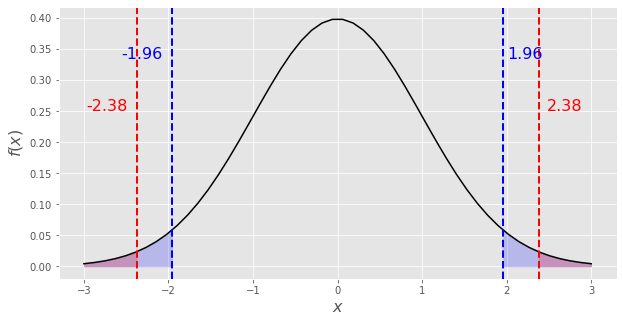

In [9]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='two-sided')

$$
\begin{aligned}
&H_0: \hspace{2mm} p_1 = p_2 \hspace{2mm} \text{На бумаге и в реальности жмут на кнопку одинаково часто} \\
&H_1: \hspace{2mm} p_1 > p_2  \hspace{2mm} \text{На бумаге на кнопку жмут чаще}
\end{aligned}
$$

В случае односторонней альтернативы ошибка 1 рода, $\alpha$, переносится на один из хвостов. 

'p-value: 0.0087'

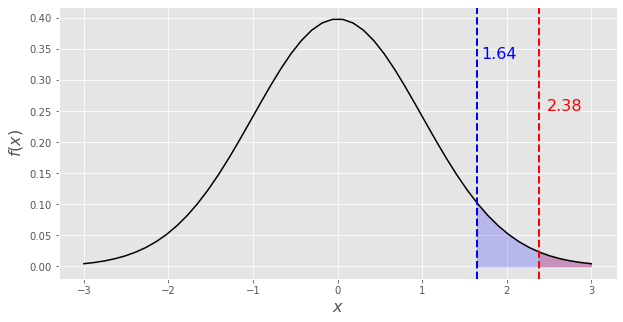

In [10]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger')

То же самое средствами `statsmodels`. 

In [11]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05                                       # уровень значимости = 5%
n_obs = paper.size, real.size                      # размеры выборок
m_obs = paper.sum(), real.sum()                    # число успехов

z_obs, p_val =  proportions_ztest(m_obs, n_obs, value=0, 
                                  alternative='larger')

print(f'Наблюдаемое значение: {z_obs:.3}') 
print(f'P-значение: {p_val:.3}') 

Наблюдаемое значение: 2.38
P-значение: 0.0087


> **Вывод:** гипотеза о том, что на кнопку жмут одинаково часто отвергается. На бумаге на кнопку жмут чаще.

# 2. Среднее и кровожадность

Кровожадные люди быстро берут на себя ответственность за удар мышки током. Будем считать, что кровожадные люди принимают решение менее, чем за пять секунд. Правда ли, что люди по своей природе кровожадные? 

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu \le 5 \hspace{2mm} \text{Люди кровожадны} \\
&H_1: \hspace{2mm} \mu > 5  \hspace{2mm} \text{Люди не кровожадны}
\end{aligned}
$$

### Асимптотический тест 

In [12]:
# Асимптотический критерий
x = df['RT'].dropna().values         # выборка

alpha = 0.05                         # уровень значимости = 5%
n = x.size                           # размер выборки
mu = x.mean()                        # среднее значение
std = x.std(ddof=1)/np.sqrt(n)       # стандартное отклонение

z_obs = (mu - 5)/std                 # наблюдаемое значение статистики 
z_crit = stats.norm.ppf(1 - alpha)   # критическое значение статистики

print(f'Наблюдаемое значение {z_obs:.3} больше критического {z_crit:.3} => нулевая гипотеза отвергается')

Наблюдаемое значение 13.0 больше критического 1.64 => нулевая гипотеза отвергается


'p-value: 0.0'

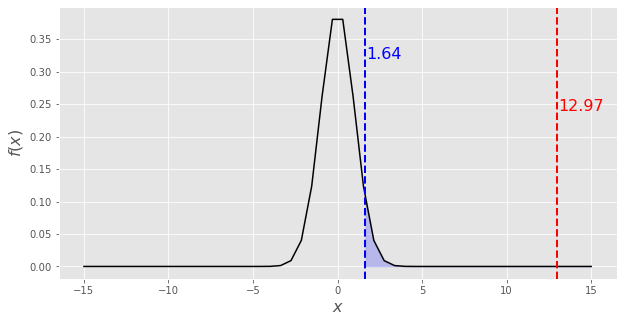

In [13]:
asy_mean_test(mu, std, mu_0=5, alpha=0.05, margin=15, alternative='larger')

То же самое средствами `statsmodels`. 

In [14]:
from statsmodels.stats.weightstats import ztest

z_obs, p_val = ztest(x, value=5, alternative='larger')

print(f"Наблюдаемое значение: {z_obs:.7}") 
print(f"P-значение: {p_val:.3}") 

Наблюдаемое значение: 12.9749
P-значение: 8.49e-39


### Точный тест 

In [15]:
t_obs = (mu - 5)/std                     # наблюдаемое значение статистики 
t_crit = stats.t(n - 1).ppf(1 - alpha)   # критическое значение статистики

print(f'Наблюдаемое значение {t_obs:.4} больше критического {t_crit:.4} => нулевая гипотеза отвергается')

Наблюдаемое значение 12.97 больше критического 1.654 => нулевая гипотеза отвергается


Каким тестом пользоваться? Точным или асимптотическим? 

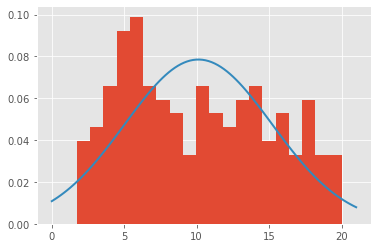

In [16]:
plt.hist(x, density=True, bins=20)

xs = np.linspace(0, 21, 100)
pdf = stats.norm(x.mean(), x.std(ddof=1)).pdf(xs)
plt.plot(xs, pdf, lw=2);

Распределение не похоже на нормальное. По аналогии с тем, что мы делали на прошлой неделе, воспользуемся тестом Колмогорова-Смирнова и проверим гипотезу о нормальности распределения колонки `RT`.

In [17]:
stats.kstest(x, 'norm', args=(df['RT'].mean(), df['RT'].std(ddof=1)))

KstestResult(statistic=0.10581791163988818, pvalue=0.045074232278964566)

Видим, что `pvalue` очень низкое, это говорит о том, что гипотеза о нормальности выборки отвергается.

> **Вывод:** гипотеза о том, что люди кровожадные отвергается. Гипотезу тестируем с помощью асимптотического критерия, так как наблюдений много, а распределение отличается от нормального.

# 3. Сравниваем кровожадность

Правда ли, что женщины намного кровожаднее мужчин и жмут на кнопку гораздо быстрее?

In [18]:
men = df[(df['GENDER'] == 1)]['RT'].dropna().values
women = df[(df['GENDER'] == 0)]['RT'].dropna().values
men

array([ 9.827884, 10.14303 ,  7.447534,  3.900421,  6.257604,  8.35017 ,
        4.851916,  4.715757,  5.502697,  2.834183, 13.204802,  6.475876,
        8.112592, 11.550315, 15.830459, 13.966976, 16.467138,  5.847557,
       14.130201,  3.897559, 17.687435,  5.059607,  5.841785,  4.766936,
       10.962231,  2.934816, 18.404679,  5.461676, 13.413565,  7.79453 ,
       17.490769,  7.060378, 16.371952,  6.683372,  3.911258,  8.673753,
       15.396327,  4.671044,  4.104334, 12.423375,  9.657467,  8.533418,
       11.257031,  2.746188, 12.626013,  5.015116,  6.508459,  6.378889,
        5.775246, 20.      ,  3.16293 , 18.733759, 11.464392, 14.289954,
        4.844785, 10.858654, 20.      ])

In [19]:
men.mean(), women.mean()

(9.373347263157894, 10.50552123853211)

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm} \text{Cкорость нажатия на кнопку одинаковая} \\
&H_1: \hspace{2mm} \mu_1 > \mu_2  \hspace{2mm} \text{Женщины жмут быстрее}
\end{aligned}
$$

Выше мы увидели, что в данных нет нормальности. Поэтому используем асимптотический тест. 

### Асимптотический тест 

In [20]:
alpha = 0.05                                                    # уровень значимости = 5%
nx, ny = women.size, men.size                                   # размер выборок

diff = women.mean() - men.mean()                                # разность средних
diff_std = np.sqrt(women.var(ddof=1)/nx + men.var(ddof=1)/ny)   # стандартное отклонение

z_obs = diff/diff_std                                           # наблюдаемое значение
z_crit = stats.norm.ppf(1 - alpha)                              # критическое значение

print(f'Наблюдаемое значение {z_obs:.5} меньше критического {z_crit:.3} => нулевая гипотеза не отвергается')

Наблюдаемое значение 1.376 меньше критического 1.64 => нулевая гипотеза не отвергается


'p-value: 0.0844'

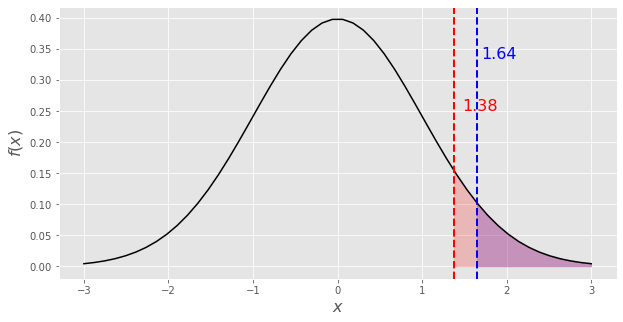

In [21]:
asy_mean_test(diff, diff_std, mu_0=0, alpha=0.05, alternative='larger')

Асимптотический тест для разных дисперсий в `statsmodels` не реализован. Есть только для равных.

> Приведём ниже код, который мы бы использовали, если бы с нормальностью выборки всё бы было хорошо. 

### Тест Стьюдента (неизвестные равные дисперсии) 

In [22]:
alpha = 0.05                                                    # уровень значимости = 5%
nx, ny = women.size, men.size                                   # размер выборок
diff = women.mean() - men.mean()                                # разность средних

diff_var = ((nx - 1)*women.var(ddof=1) + (ny - 1)*men.var(ddof=1))/(nx + ny - 2)
diff_std = np.sqrt(diff_var/nx + diff_var/ny)                   # стандартное отклонение

t_obs = diff/diff_std                                           # наблюдаемое значение
t_crit = stats.t(df = nx + ny - 2).ppf(1 - alpha)               # критическое значение

print(f'Наблюдаемое значение {t_obs:.3} меньше критического {t_crit:.3} => нулевая гипотеза не отвергается')

Наблюдаемое значение 1.37 меньше критического 1.65 => нулевая гипотеза не отвергается


То же самое средствами `statsmodels`. 

In [23]:
from statsmodels.stats.weightstats import ttest_ind

t_obs, p_val, _ = ttest_ind(women, men, value=0, alternative='larger')

print(f"Наблюдаемое значение: {t_obs:.3}") 
print(f"P-значение: {p_val:.3}") 

Наблюдаемое значение: 1.37
P-значение: 0.0868


### Тест Уэлча (неизвестные разные дисперсии) 

In [24]:
alpha = 0.05                                                    # уровень значимости = 5%
nx, ny = women.size, men.size                                   # размер выборок

diff = women.mean() - men.mean()                                # разность средних
diff_std = np.sqrt(women.var(ddof=1)/nx + men.var(ddof=1)/ny)   # стандартное отклонение

t_obs = diff/diff_std                                           # наблюдаемое значение

# число степеней свободы
u = (women.var(ddof=1) / nx + men.var(ddof=1) / ny) ** 2
d = (women.var(ddof=1)**2) / (nx**2 * (nx - 1)) + (men.var(ddof=1)**2)/ (ny**2* (ny - 1))
nu =  u/d 

t_crit = stats.t(nu).ppf(1 - alpha)                             # критическое значение

print(f'Наблюдаемое значение {t_obs:.3} меньше критического {t_crit:.3} => нулевая гипотеза не отвергается')

Наблюдаемое значение 1.38 меньше критического 1.66 => нулевая гипотеза не отвергается


In [25]:
women.std(ddof=1), men.std(ddof=1)

(5.103972224167936, 4.996830829492464)

In [26]:
nx, ny # направление знака между наблюдениями соотвествует знаку между дисперсиями

(109, 57)

То же самое средствами `statsmodels`. 

In [27]:
from statsmodels.stats.weightstats import ttest_ind

# usevar опционально думает, что дисперсии одинаковые
t_obs, p_val, _ = ttest_ind(women, men, value=0, 
                            alternative='larger', usevar='unequal')

print(f"Наблюдаемое значение: {t_obs:.3}") 
print(f"P-значение: {p_val:.3}") 

Наблюдаемое значение: 1.38
P-значение: 0.0857


> **Вывод:** используем асимптотический критерий. Гипотеза о том, что женщины жмут на кнопку с такой же скоростью, как и мужчины не отвергается. Мужчины и женщины одинаково кровожадны.

# 4. Эмпатия

Перед экспериментом каждый участник проходил психологический тест. Для каждого человека рассчитывалось довольно большое число параметров, описывающих его психотип. Например, в колонках `EC` находится оценка способности человека к эмпатии [(Empathic concern),](https://en.wikipedia.org/wiki/Empathic_concern) в колонке `AE` находится оценка эмпатии человека к животным. 



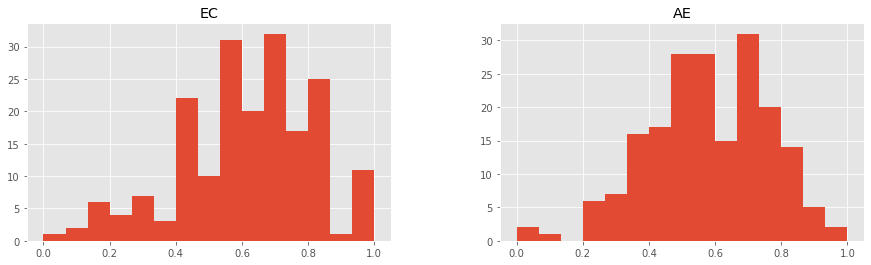

In [28]:
# Отнормируем наблюдения от 0 до 1 для корректного сравнения
df['EC'] = (df['EC'] - df['EC'].min())/(df['EC'].max() - df['EC'].min())
df['AE'] = (df['AE'] - df['AE'].min())/(df['AE'].max() - df['AE'].min())

df[['EC', 'AE']].hist(bins=15, figsize=(15,4));

Правда ли, что неоднородность людей в плане их эмпатии к животным намного выше неоднородности в плане обычной эмпатии? 

$$
\begin{aligned}
&H_0: \hspace{2mm} \sigma^2_1 = \sigma^2_2 \hspace{2mm} \text{Неоднородность одинаковая} \\
&H_1: \hspace{2mm} \sigma^2_1 < \sigma^2_2  \hspace{2mm} \text{Неоднородность для животных выше}
\end{aligned}
$$

Распределения нормальные, можем использовать F-статистику. 

In [29]:
ec = df['EC'].dropna().values
ae = df['AE'].dropna().values

ec.mean(), ae.mean()

(0.6190814394131477, 0.5798980496933709)

In [30]:
ec.var(), ae.var()

(0.04247637731538298, 0.03204691694434707)

In [31]:
alpha = 0.05                             # уровень значимости = 5%
nx, ny = ec.size, ae.size                # размер выборок

F_obs = ec.var()/ae.var()                # наблюдаемое значение

f_rv = stats.f(nx - 1, ny - 1) 
F_crit = f_rv.ppf(1 - alpha/2)           # критическое значение

print(f'Наблюдаемое значение {F_obs:.5} меньше критического {F_crit:.5} => нулевая гипотеза не отвергается')

Наблюдаемое значение 1.3254 меньше критического 1.3291 => нулевая гипотеза не отвергается


> Гипотеза о равенстве дисперсий не отвергается, однако она оказывается малозначима.